In [187]:
import pandas as pd
from biolearn.data_library import DataLibrary
from biolearn.model_gallery import ModelGallery
import seaborn as sns
import matplotlib.pyplot as plt
gallery = ModelGallery()
data_path='/data/gladyshev/mm1286/data/'

types={'cd4t':'cd4',
       'cd4nv':'cd4n',
       'CD4n':'cd4n',
       'cd8t':'cd8',
       'cd8nv':'cd8n',
       'Tn':'cd8n',
       'bcell':'b',
       'monocytes':'mono',
       'neutrophils':'neu',
       'granulocytes':'gran'
      }

In [105]:
man=pd.read_csv(data_path+'/aging-genes/man_e1.csv',index_col=0,usecols=['IlmnID','g','ch','pos','dis','gene'])

In [106]:
wb = DataLibrary().get("GSE112618").load()
wb_meta=wb.metadata
wb_meta=wb_meta[[c for c in wb_meta.columns if '_proportion' in c]].astype(float)
wb_meta.columns=[c.rstrip('_proportion') for c in wb_meta.columns]
wb_meta=wb_meta.T
dnam_wb=wb.dnam
wb_meta=wb_meta.rename(index=types)    

In [107]:
%%time
mat1=data_path+'ref/cell_comp/GSE110554_series_matrix.txt'
meta1=pd.read_table(mat1,nrows=10**2,skiprows=38,index_col=0)
meta1['GSM2998097']=meta1['GSM2998097'].shift(-1)
meta1['GSM2998106']=meta1['GSM2998106'].shift(-1)
meta1=meta1.iloc[14:20]
meta1.index=meta1.iloc[:,0].str.split(': ').str[0]
for c in meta1.columns:
    meta1[c]=meta1[c].str.split(': ').str[1].astype(int)/100
meta1=meta1.rename(index=types)    
dnam1=pd.read_table(mat1,nrows=10**6,skiprows=38+59,index_col=0)
dnam1=dnam1.drop('!series_matrix_table_end')

CPU times: user 5.44 s, sys: 935 ms, total: 6.38 s
Wall time: 14.1 s


In [108]:
%%time
mat2=data_path+'ref/cell_comp/GSE167998_matrix_processed.txt'
dnam2=pd.read_table(mat2,nrows=10**6,index_col=0,skiprows=0,usecols=[0]+list(range(1,136,2)))

CPU times: user 14.1 s, sys: 1.43 s, total: 15.5 s
Wall time: 18.8 s


In [109]:
meta2_='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE167nnn/GSE167998/matrix/GSE167998_series_matrix.txt.gz'
meta2=pd.read_table(meta2_,skiprows=38,index_col=0,nrows=1,header=None).T
meta2['!Sample_title']=meta2['!Sample_title'].str[:4]
meta2.index=dnam2.columns
meta2=meta2.squeeze()
meta_m2=meta2[meta2=='mem ']
meta2=meta2[meta2!='mem ']
meta2.loc[meta2.str[:2]=='Bn']='Bn'
meta2.loc[meta2.str[:2]=='Tn']='Tn'
meta2.loc[meta2.str[:2]=='NK']='NK'
meta2.loc[(meta2.str[:2]=='WB')|(meta2=='PCA0')|(meta2=='Neut')]='Neu'

In [110]:
%%time
meta_mix2=pd.read_table(meta2_,skiprows=39,index_col=0,nrows=50).iloc[34:47]
meta_mix2.columns=dnam2.columns
meta_mix2=meta_mix2[meta_m2.index]
meta_mix2.index=meta_mix2.iloc[:,0].str.split(': ').str[0]
for c in meta_mix2.columns:
    meta_mix2[c]=meta_mix2[c].str.split(': ').str[1].astype(float)
meta_mix2=meta_mix2.rename(index=types)        

CPU times: user 119 ms, sys: 2.72 ms, total: 121 ms
Wall time: 388 ms


In [111]:
umb_meta=pd.read_table(data_path+'ref/cell_comp/GSE180970_series_matrix.txt',skiprows=38,index_col=0,nrows=40).iloc[7:13]
umb_meta.index=umb_meta.iloc[:,0].str.split(': ').str[0]
umb_meta=umb_meta.rename(index=types)
for c in umb_meta.columns:
    umb_meta[c]=umb_meta[c].str.split(': ').str[1].astype(float)/100
umb=pd.read_table(data_path+'ref/cell_comp/GSE180970_series_matrix.txt',skiprows=37+40,index_col=0)        

In [215]:
meta=pd.concat([wb_meta,meta1,meta_mix2,umb_meta],axis=1)
meta.loc[len(meta)] = pd.Series(dtype='float64')
meta.index=list(meta.index[:-1])+['cd8n']
meta.shape

(14, 79)

In [216]:
meta2=meta2.replace(types)

In [217]:
for c in meta2.index:
    if meta2.loc[c] in ['cd4n','cd8n']:
        tmp=pd.Series([1],index=[meta2.loc[c]]).rename(c)
        meta=meta.join(tmp)

In [220]:
cd4n=meta.loc['cd8n'].dropna()
cd4n.shape

(5,)

In [221]:
cd4n

203027390100_R06C01    1.0
203027390094_R05C01    1.0
203027390092_R03C01    1.0
203027390051_R01C01    1.0
203013220070_R01C01    1.0
Name: cd8n, dtype: float64

In [158]:
%%time
cd4n_cor=dnam[cd4n.index].T.corrwith(cd4n,method='spearman')

/PHShome/mm1286/anaconda3/envs/p311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


CPU times: user 6min 5s, sys: 3.01 s, total: 6min 8s
Wall time: 6min 9s


In [173]:
cd4n_cor.sort_values().dropna().tail(10)

cg11612786    0.958042
cg07941916    0.965035
cg06360218    0.965035
cg25252598    0.965035
cg24861399    0.965035
cg03054890    0.965035
cg19399817    0.972028
cg18503234    0.972028
cg25004855    0.979021
cg17565444    0.986014
dtype: float64

<Axes: xlabel='cd4n', ylabel='cg17565444'>

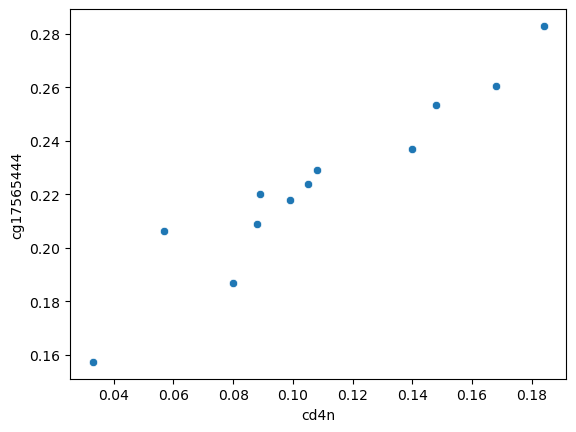

In [181]:
sns.scatterplot(data=dnam.T,y='cg17565444',x=cd4n)

In [182]:
cd4n_cor.sort_values().tail(10).index

Index(['cg26643754', 'cg26657539', 'cg26870126', 'cg27141489', 'cg27179352',
       'cg27194210', 'cg27379210', 'cg27509373', 'cg27598632', 'cg27634880'],
      dtype='object')

In [30]:
dnam=pd.concat([dnam_wb,dnam1,dnam2,umb],axis=1).drop('!series_matrix_table_end')
dnam.shape

(866091, 135)

In [931]:
t=pd.concat([wb,mix,dnam[meta_mix2.columns],umb],axis=1)
t.shape

(866092, 42)

In [932]:
tp=pd.DataFrame(pd.concat([cells['cd4'],meta_mix.loc['CD4'],meta_mix2.loc['cd4'],umb_meta['cd4']]))
tp.shape

(42, 1)

In [934]:
tp['type']=6*[0]+12*[1]+12*[2]+12*[3]

In [935]:
tt=t.T.join(tp)
tt.shape

(42, 866094)

In [ ]:
%%time
cors=[]
for i in range(0,4):
    cors.append(tt[tt['type']==i].corrwith(tt[0]))

/PHShome/mm1286/anaconda3/envs/p311/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/PHShome/mm1286/anaconda3/envs/p311/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [937]:
cors_df=pd.concat(cors,axis=1)

In [940]:
cors_df.loc['cg15619756']

0    0.847771
1    0.275954
2    0.799267
3   -0.315275
m    0.401929
Name: cg15619756, dtype: float64

In [939]:
cors_df['m']=cors_df.mean(1)
cors_df.sort_values('m').head(50).join(man)

,0,1,2,3,m,ch,pos,g,dis,gene
cg01210399,-0.976250,-0.884398,-0.899680,-0.810632,-0.892740,1,84635169,1084635169,-55120,SSX2IP
cg06376547,-0.968339,-0.889072,-0.847990,-0.788148,-0.873388,15,63390221,15063390221,8375,CA12
cg12464177,-0.894650,-0.864440,-0.952018,-0.780181,-0.872822,17,35708249,17035708249,-23390,RASL10B
cg22033073,-0.943321,-0.878632,-0.877921,-0.788574,-0.872112,16,21596896,16021596896,-326,METTL9
cg11778706,-0.822270,-0.919614,-0.875602,-0.826279,-0.860941,8,22646038,8022646038,1234,BIN3
cg07901251,-0.967677,-0.787699,-0.839049,-0.813749,-0.852043,14,23033832,14023033832,-895,PSMB5
cg23075732,-0.908812,-0.841910,-0.848658,-0.791898,-0.847819,2,157784609,2157784609,-22387,ACVR1
cg00219233,-0.870346,-0.777369,-0.923582,-0.812658,-0.845989,7,44449284,7044449284,-41374,NUDCD3
cg17518643,-0.895220,-0.879406,-0.702811,-0.847613,-0.831263,13,99317018,13099317018,9619,GPR183
cg03754418,-0.990782,-0.622853,-0.897257,-0.804582,-0.828869,2,203732157,2203732157,25518,CD28


In [ ]:
t.loc[['cg03855955']].T.corrwith(tp[0])

NameError: name 't' is not defined

<Axes: xlabel='0', ylabel='cg03855955'>

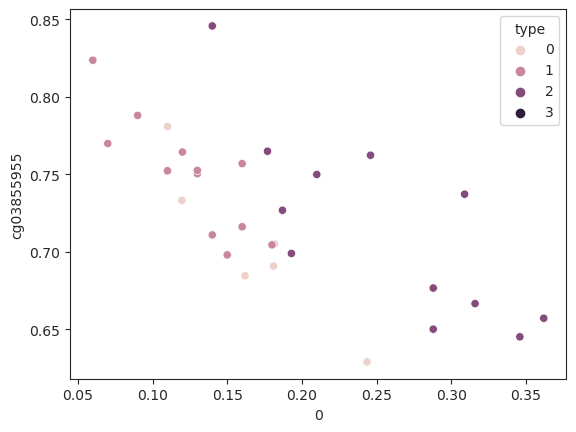

In [852]:
sns.scatterplot(x=tp[0],y=t.loc['cg03855955'],hue=tp['type'])

In [928]:
%%time
cd4n=t[meta_mix2.columns].T.corrwith(meta_mix2.loc['cd4n'])

/PHShome/mm1286/anaconda3/envs/p311/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/PHShome/mm1286/anaconda3/envs/p311/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


CPU times: user 4min 20s, sys: 2.1 s, total: 4min 22s
Wall time: 10min 4s


In [929]:
cd4n.sort_values()

cg07650392                 -0.975633
cg22595657                 -0.968410
cg12518834                 -0.959513
cg07729711                 -0.959509
cg15165643                 -0.955367
                              ...   
cg27379210                       NaN
cg27509373                       NaN
cg27598632                       NaN
cg27634880                       NaN
!series_matrix_table_end         NaN
Length: 866092, dtype: float64

Text(0.5, 1.0, 'Deconvolution Validation - FACS')

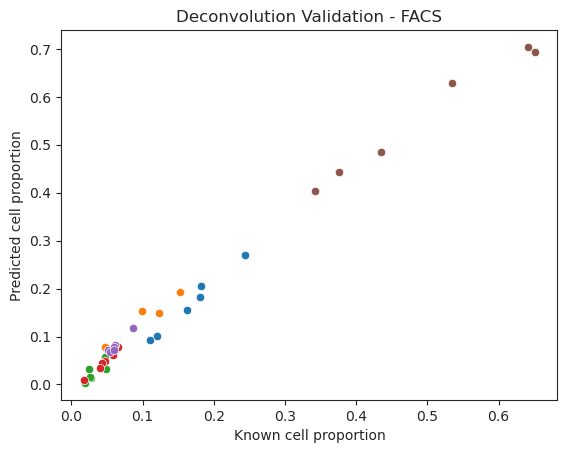

In [107]:
for cell in types:
    pl=pd.concat([cells[cell], pred[cell]],axis=1)
    pl.columns=['cell','pred']
    sns.scatterplot(data=pl,x='cell',y='pred')
plt.xlabel("Known cell proportion")
plt.ylabel("Predicted cell proportion")
plt.title("Deconvolution Validation - FACS")